## Import Libraries and Dataset

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import glob
import random
import time
import cv2

%matplotlib inline

In [16]:
# Raw data
data_map = []
for sub_dir_path in glob.glob("*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("Not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head() 


Not a dir: brain_MRI.ipynb
Not a dir: class_model.json
Not a dir: class_weights.hdf5
Not a dir: data.csv
Not a dir: generator.py
Not a dir: losses.py
Not a dir: prediction.py
Not a dir: README.md
Not a dir: seg_model.json
Not a dir: seg_weights.hdf5


,dirname,path
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10...
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10...
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11...
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11...


In [17]:
# Get lenths of the image and mask paths for sorting
base_len = len("TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_")
img_len = len("TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif")
mask_len = len("TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif")

# Differentiated lengths of the file suffix numbers (and if it contains mask or not)
img_suffix = img_len - base_len
mask_suffix = mask_len - base_len

# print results
print("Base length: " + str(base_len))
print("Img length: " + str(img_suffix))
print("Mask length: " + str(mask_suffix))


Base length: 44
Img length: 5
Mask length: 10


In [18]:
# Masks vs not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key= lambda x : int(x[44:-4]))
masks = sorted(df_masks["path"].values, key= lambda x : int(x[44:-9]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to img:", imgs[idx], "\nPath to mask:", masks[idx])

Path to img: TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_19.tif 
Path to mask: TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_19_mask.tif


## Perform Data Exploration and Visualization


In [76]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                        "image_path": imgs,
                        "mask_path": masks})

df.head()

,patient,image_path,mask_path
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
1,TCGA_CS_4941_19960909,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...
2,TCGA_CS_4941_19960909,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
3,TCGA_CS_4941_19960909,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
4,TCGA_CS_4941_19960909,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...


In [77]:
# Adding column for diagnosis
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda x: diagnosis(x))
df.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
1,TCGA_CS_4941_19960909,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
2,TCGA_CS_4941_19960909,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
3,TCGA_CS_4941_19960909,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
4,TCGA_CS_4941_19960909,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0


In [78]:
df.value_counts("diagnosis")

diagnosis
0    2556
1    1373
dtype: int64

In [22]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(
    x = df['diagnosis'].value_counts().index, 
    y = df['diagnosis'].value_counts(),
    )])

fig.update_traces(marker_color = 'rgb(254,127,156)', marker_line_color = 'rgb(231,84,128)',
                  marker_line_width = 6, opacity = 0.7)

fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=["Negative", "Positive"]
)

fig.update_layout(
    title='Diagnosis Distribution',
    xaxis=dict(title='Diagnosis'),
    yaxis=dict(title='Total Images'),
)
fig.show()

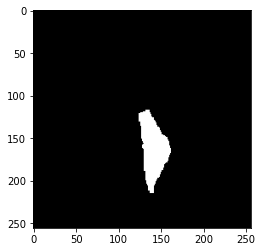

In [23]:
#df[df["diagnosis"] == 1].sample(1).image_path.index # 2751
plt.imshow(cv2.imread(df.mask_path[2751]))

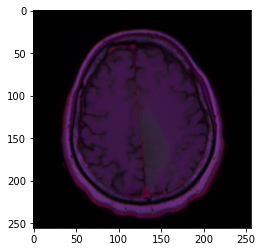

In [24]:
plt.imshow(cv2.imread(df.image_path[2751]))

In [25]:
# Check pixel values
cv2.imread(df.mask_path[2751]).max()

255

In [26]:
# Check pixel values
cv2.imread(df.mask_path[2751]).min()

0

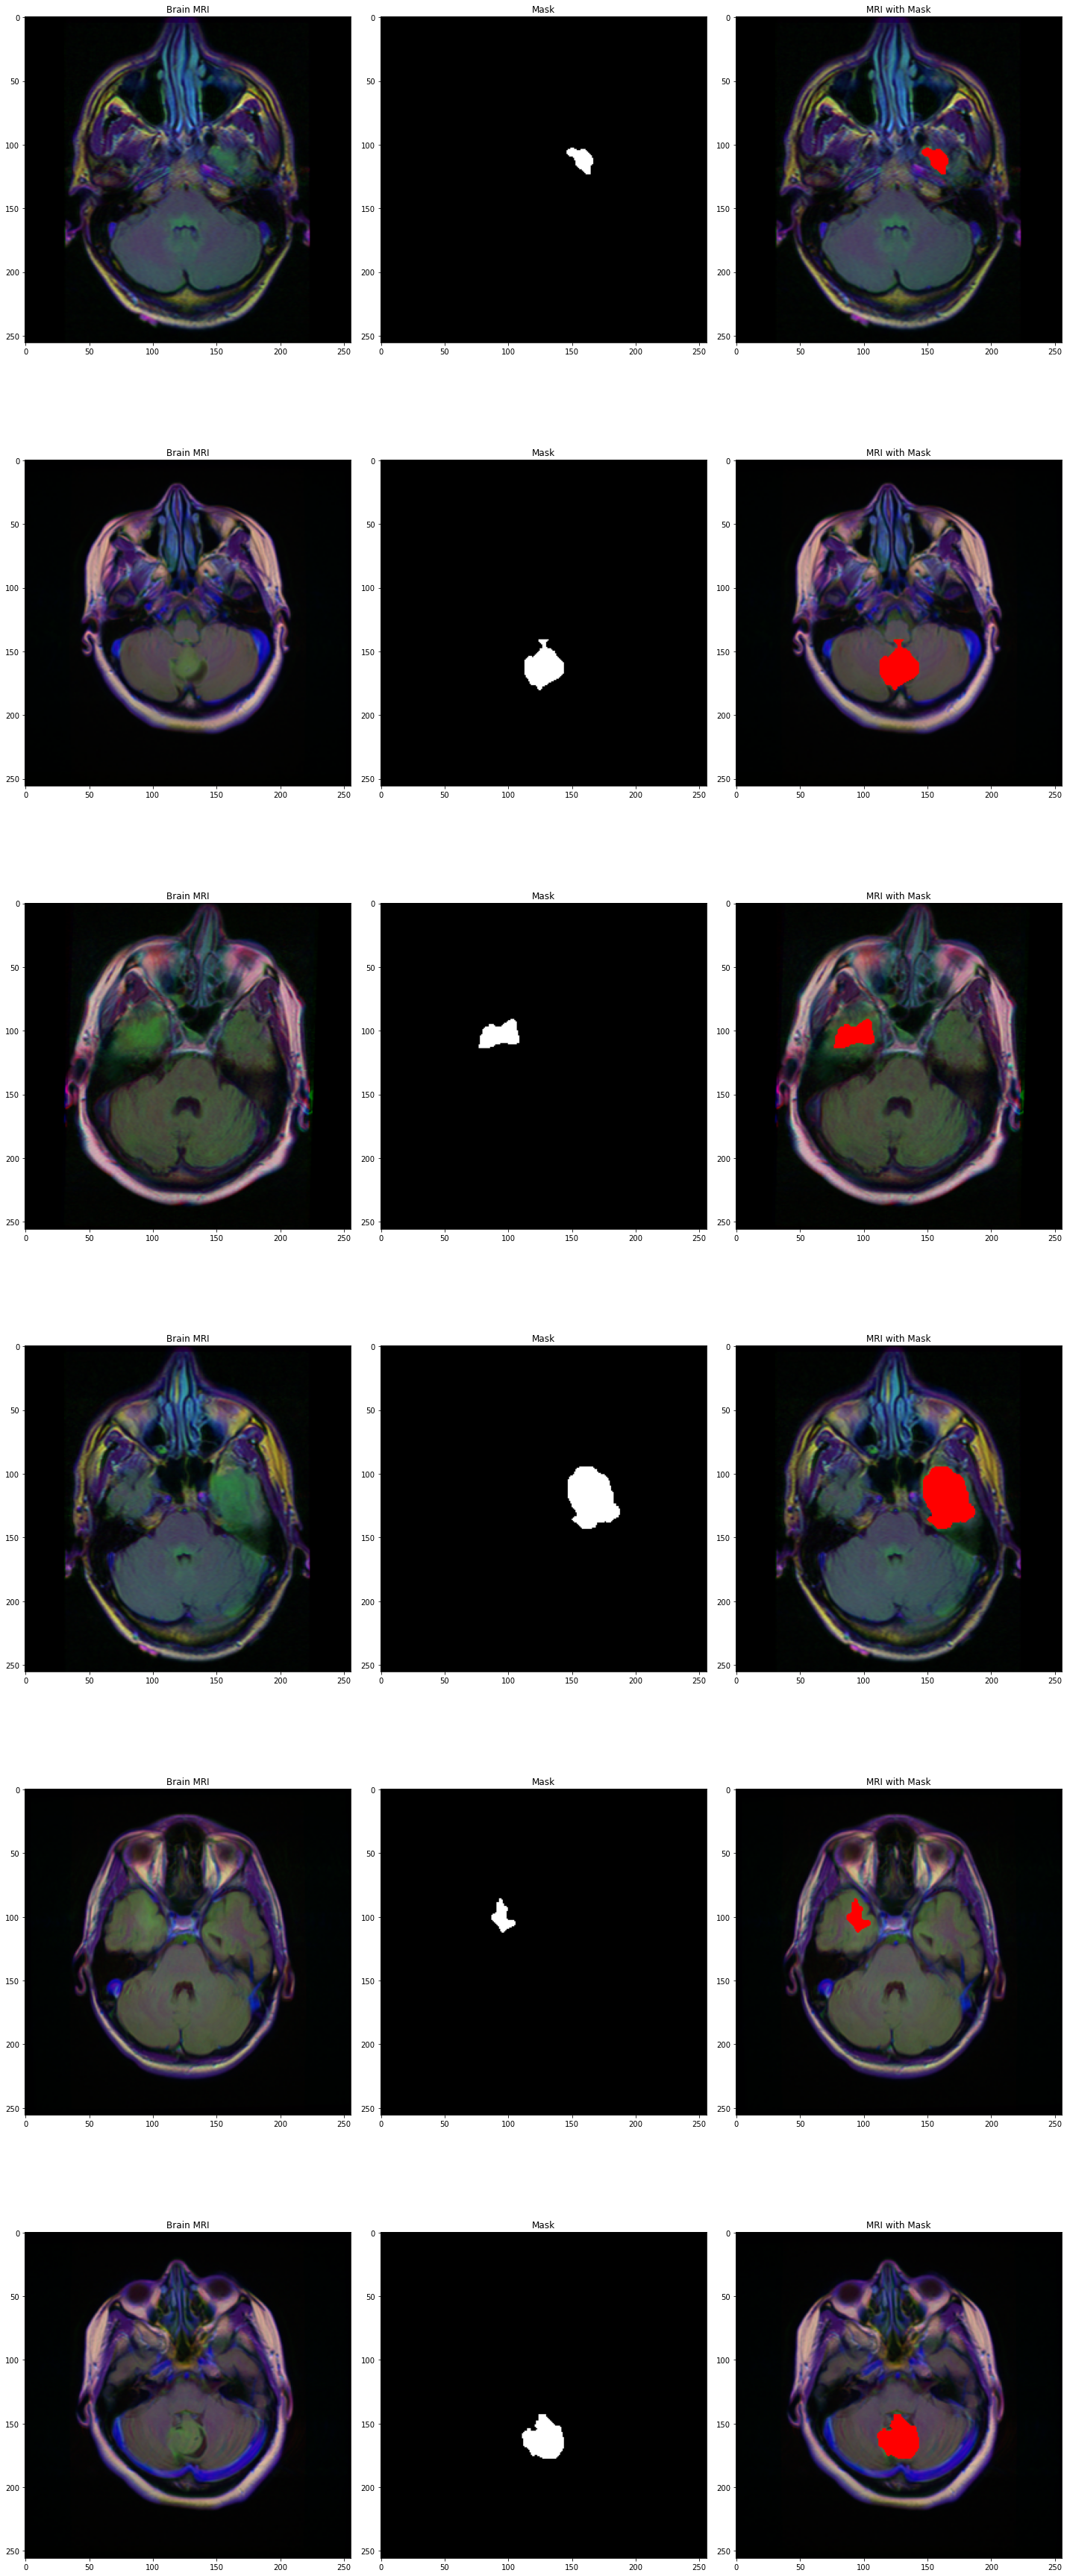

In [27]:
# Show the images and masks and highlight the masks
from skimage import io
count = 0
fig, axs = plt.subplots(6, 3, figsize = (20, 50))
for i in range(len(df)):
  if df['diagnosis'][i] ==1 and count <6:
    img = io.imread(df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    # Load the mask
    mask = io.imread(df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    # Replace the mask pixels with the color red
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

## Train a Classifier Model to Detect if a Tumor is Present

In [28]:
# Importing more libraries
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

In [29]:
# Drop patient id column not needed for training
df_train = df.drop(columns = ['patient'])
df_train.head()

,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
1,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
2,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
3,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
4,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0


In [30]:
# Convert diagnosis column to string to use categorically
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: str(x))


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   diagnosis   3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [32]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_train, test_size= 0.15)

In [33]:
# Create an image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator - generate images in batches
data_generator = ImageDataGenerator(rescale= 1./255., validation_split= 0.15) # allocating 15% of the data for validation

In [34]:
# Create a data generator for the training data 
train_generator = data_generator.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'diagnosis',
    subset = 'training',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size=(256, 256)
)

# Create a data generator for the validation data
valid_generator = data_generator.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'diagnosis',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size=(256, 256)
)

# Create a data generator for the test data - to use at the end
test_data_generator = ImageDataGenerator(rescale= 1./255.)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'diagnosis',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size=(256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [35]:
# Obtain ResNet50 model
base_model = ResNet50(weights= 'imagenet', include_top= False, input_tensor= Input(shape= (256, 256, 3)))

In [36]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [37]:
# freeze the layers in the base model
for layer in base_model.layers:
    layers.trainable = False

In [38]:
# Add custom layers for classification
x = base_model.output
x = AveragePooling2D(pool_size = (4,4))(x)
x = Flatten()(x)  
x = Dense(256, activation='relu')(x)  
x = BatchNormalization()(x)  
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)  
x = BatchNormalization()(x)  
x = Dropout(0.3)(x)    
predictions = Dense(2, activation='softmax')(x)


model = Model(inputs= base_model.input, outputs= predictions)




In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [40]:
# Compile the model
model.compile(optimizer= Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [41]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


checkpoint = ModelCheckpoint("class_weights2.hdf5", monitor= 'val_loss', verbose= 1, save_best_only= True) # added 2 to file name to avoid overwriting the main model


In [28]:

history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.n // 32, 
    epochs= 1,
    validation_data= valid_generator,
    validation_steps= valid_generator.n // 32, 
    callbacks= [early_stopping, checkpoint]
)

# Originally ran for 100 epochs to get the model that is assessed in the next section
# Informtation below is from a single run to showcase code working


88/88 [==============================] - 404s 5s/step - loss: 0.7023 - accuracy: 0.7219 - val_loss: 0.6581 - val_accuracy: 0.6458

Epoch 00001: val_loss improved from inf to 0.65807, saving model to best_class_model.hdf5


c:\Users\korin\anaconda3\envs\capstone2\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [29]:
# Save the model for later use
model_json = model.to_json()
with open("class_model2.json", "w") as json_file: # added 2 to file name to avoid overwriting the main model
    json_file.write(model_json)

## Assessing Model Performance

In [42]:
# Open the model and load the weights
with open('class_model.json', 'r') as json_file:
    json_Model= json_file.read()
# Load the model
model = tf.keras.models.model_from_json(json_Model)
model.load_weights('class_weights.hdf5')
model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [43]:
# Make a prediction
test_predict = model.predict(test_generator, steps= test_generator.n // 16, verbose= 1)

36/36 [==============================] - 35s 932ms/step


In [44]:
# Check the shape of the prediction
test_predict.shape

(576, 2)

In [45]:
# Obtain the predicted class (0 or 1) from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [46]:
# Check prediction array
predict

array(['1', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0',
       '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0',
       '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0',
       '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1',
       '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1',
       '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1',
       '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0',
       '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1

In [47]:
# Create a dataframe to store the predicted diagnosis that will have the same length as the test dataframe
primary = np.asarray(test['diagnosis'])[:len(predict)]
len(primary)

576

In [48]:
# Obtain the accuracy score of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(primary, predict)
accuracy

0.9861111111111112

<AxesSubplot:>

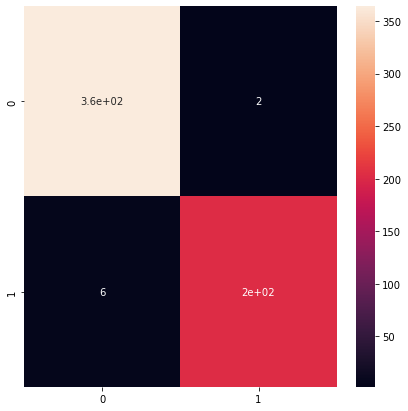

In [49]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(primary, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [50]:
# Obtain the classification report
from sklearn.metrics import classification_report

report = classification_report(primary, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       366
           1       0.99      0.97      0.98       210

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.98      0.98       576
weighted avg       0.99      0.99      0.99       576



c:\Users\korin\anaconda3\envs\capstone2\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

c:\Users\korin\anaconda3\envs\capstone2\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

c:\Users\korin\anaconda3\envs\capstone2\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

c:\Users\korin\anaconda3\envs\capstone2\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



## Building a Segmentation Model to Localize Brain Tumors

In [51]:
# Obtain all MRIS with diagnosis 1
df_mask = df[df['diagnosis'] == 1]
df_mask.shape

(1373, 4)

In [52]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(df_mask, test_size= 0.15)
X_test, X_val = train_test_split(X_val, test_size= 0.5)

In [53]:
# Create lists of the image and mask paths to use in the data generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)


In [54]:
# Importing custom generator from the generator file
from generator import DataGenerator

# Create image generators

training_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

In [55]:
# Create a resblock
def resblock(x, f):
  # Make a copy of input
  x_copy = x
  # MAIN PATH
  x = Conv2D(f, kernel_size= (1, 1), strides= (1, 1), kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(f, kernel_size= (3, 3), strides= (1, 1), padding= 'same', kernel_initializer= 'he_normal')(x)
  x = BatchNormalization()(x)
  # SHORT PATH
  x_copy = Conv2D(f, kernel_size= (1, 1), strides= (1, 1), kernel_initializer= 'he_normal')(x_copy)
  x_copy = BatchNormalization()(x_copy)
  # Adding the output from main path and short path together
  x = Add()([x,x_copy])
  x = Activation('relu')(x)

  return x

In [56]:
# Upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2, 2))(x)
  concat = Concatenate()([x, skip])

  return concat

In [57]:
# Building the network

input_shape = (256, 256, 3)
# Input tensor shape
x_input = Input(input_shape)
# Stage 1 of the network
conv1_in = Conv2D(16, 3, activation= 'relu', padding= 'same', kernel_initializer= 'he_normal')(x_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation= 'relu', padding= 'same', kernel_initializer= 'he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size= (2, 2))(conv1_in)
# Stage 2 of the network
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size= (2, 2))(conv2_in)
# Stage 3 of the network
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size= (2, 2))(conv3_in)
# Stage 4 of the network
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size= (2, 2))(conv4_in)
# Stage 5 (Bottle Neck) of the network
conv5_in = resblock(pool_4, 256)

# Upscale stage 1 of the network
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)
# Upscale stage 2 of the network
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)
# Upscale stage 3 of the network
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)
# Upscale stage 4 of the network
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1, 1), padding= "same", activation= "sigmoid")(up_4)

seg_model = Model(inputs= x_input, outputs= output )

In [58]:
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization_2[0][0]      
____________________________________________________________________________________________

## Training the Segmentation Resunet Model to Localize Tumors in MRIs

In [59]:
# Adding custom loss functions (adapted from: https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
def tversky(y_true, y_pred, smooth= 1e-6):
    y_true_pos = K.cast(K.flatten(y_true), 'float32')
    y_pred_pos = K.cast(K.flatten(y_pred), 'float32')
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def focal_tversky(y_true, y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)


In [60]:
# Compiling the model
adam = tf.keras.optimizers.Adam(learning_rate= 0.05, epsilon= 0.1)
seg_model.compile(optimizer= adam, loss= focal_tversky, metrics= [tversky])

In [61]:
# Setting up the callbacks
early_stopping = EarlyStopping(monitor= 'val_loss', mode= 'min', verbose= 1, patience= 10)

checkpoint = ModelCheckpoint(filepath= "seg_weights2.hdf5", verbose= 1, save_best_only= True) # added 2 to file name to avoid overwriting the main model


In [272]:
# Train the model
history = seg_model.fit(
    training_generator, 
    epochs= 1, 
    validation_data= validation_generator, 
    callbacks= [checkpoint, early_stopping]
    )
# Originally ran for 100 epochs to get the model that is assessed in the next section
# Informtation below is from a single run to showcase code working

72/72 [==============================] - 306s 4s/step - loss: 0.9577 - tversky: 0.0560 - val_loss: 0.9555 - val_tversky: 0.0589

Epoch 00001: val_loss improved from inf to 0.95545, saving model to seg_weights2.hdf5


c:\Users\korin\anaconda3\envs\capstone2\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [273]:
# Save the model architecture to json file for future use
model_json = seg_model.to_json()
with open("seg_model2.json", "w") as json_file: # added 2 to file name to avoid overwriting the main model
  json_file.write(model_json)

## Assessing Segmentation Model Performance

In [79]:
# Open the model and load the weights
with open('seg_model.json', 'r') as json_file:
    json_Model= json_file.read()
seg_model = tf.keras.models.model_from_json(json_Model)
seg_model.load_weights('seg_weights.hdf5')
seg_model.compile(optimizer= 'adam', loss= focal_tversky, metrics= [tversky])

In [80]:
from prediction import prediction

# Make a prediction
image_id, mask, has_mask = prediction(test, model, seg_model)

In [81]:
# Creating a dataframe for the result
pred_df = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
pred_df

,image_path,predicted_mask,has_mask
0,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_23...,"[[[[7.3668946e-07], [2.8420645e-06], [6.526529...",1
1,TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_22...,"[[[[6.0661097e-07], [2.0100872e-06], [3.930234...",1
2,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_14...,"[[[[7.275598e-07], [2.952758e-06], [7.678611e-...",1
3,TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_2.tif,No mask,0
4,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1.tif,No mask,0
...,...,...,...
585,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_24...,No mask,0
586,TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_9.tif,No mask,0
587,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_14...,"[[[[7.610652e-07], [2.5504908e-06], [4.6286686...",1
588,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_34...,"[[[[8.2177525e-07], [2.9201e-06], [6.1279798e-...",1


In [82]:
# Merge the dataframe containing predicted results with the original test data.
comb_df = test.merge(pred_df, on = 'image_path')
comb_df.head()

,image_path,mask_path,diagnosis,predicted_mask,has_mask
0,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_23...,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_23...,1,"[[[[7.3668946e-07], [2.8420645e-06], [6.526529...",1
1,TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_22...,TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_22...,1,"[[[[6.0661097e-07], [2.0100872e-06], [3.930234...",1
2,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_14...,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_14...,1,"[[[[7.275598e-07], [2.952758e-06], [7.678611e-...",1
3,TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_2.tif,TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_2_...,0,No mask,0
4,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1.tif,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1_...,0,No mask,0


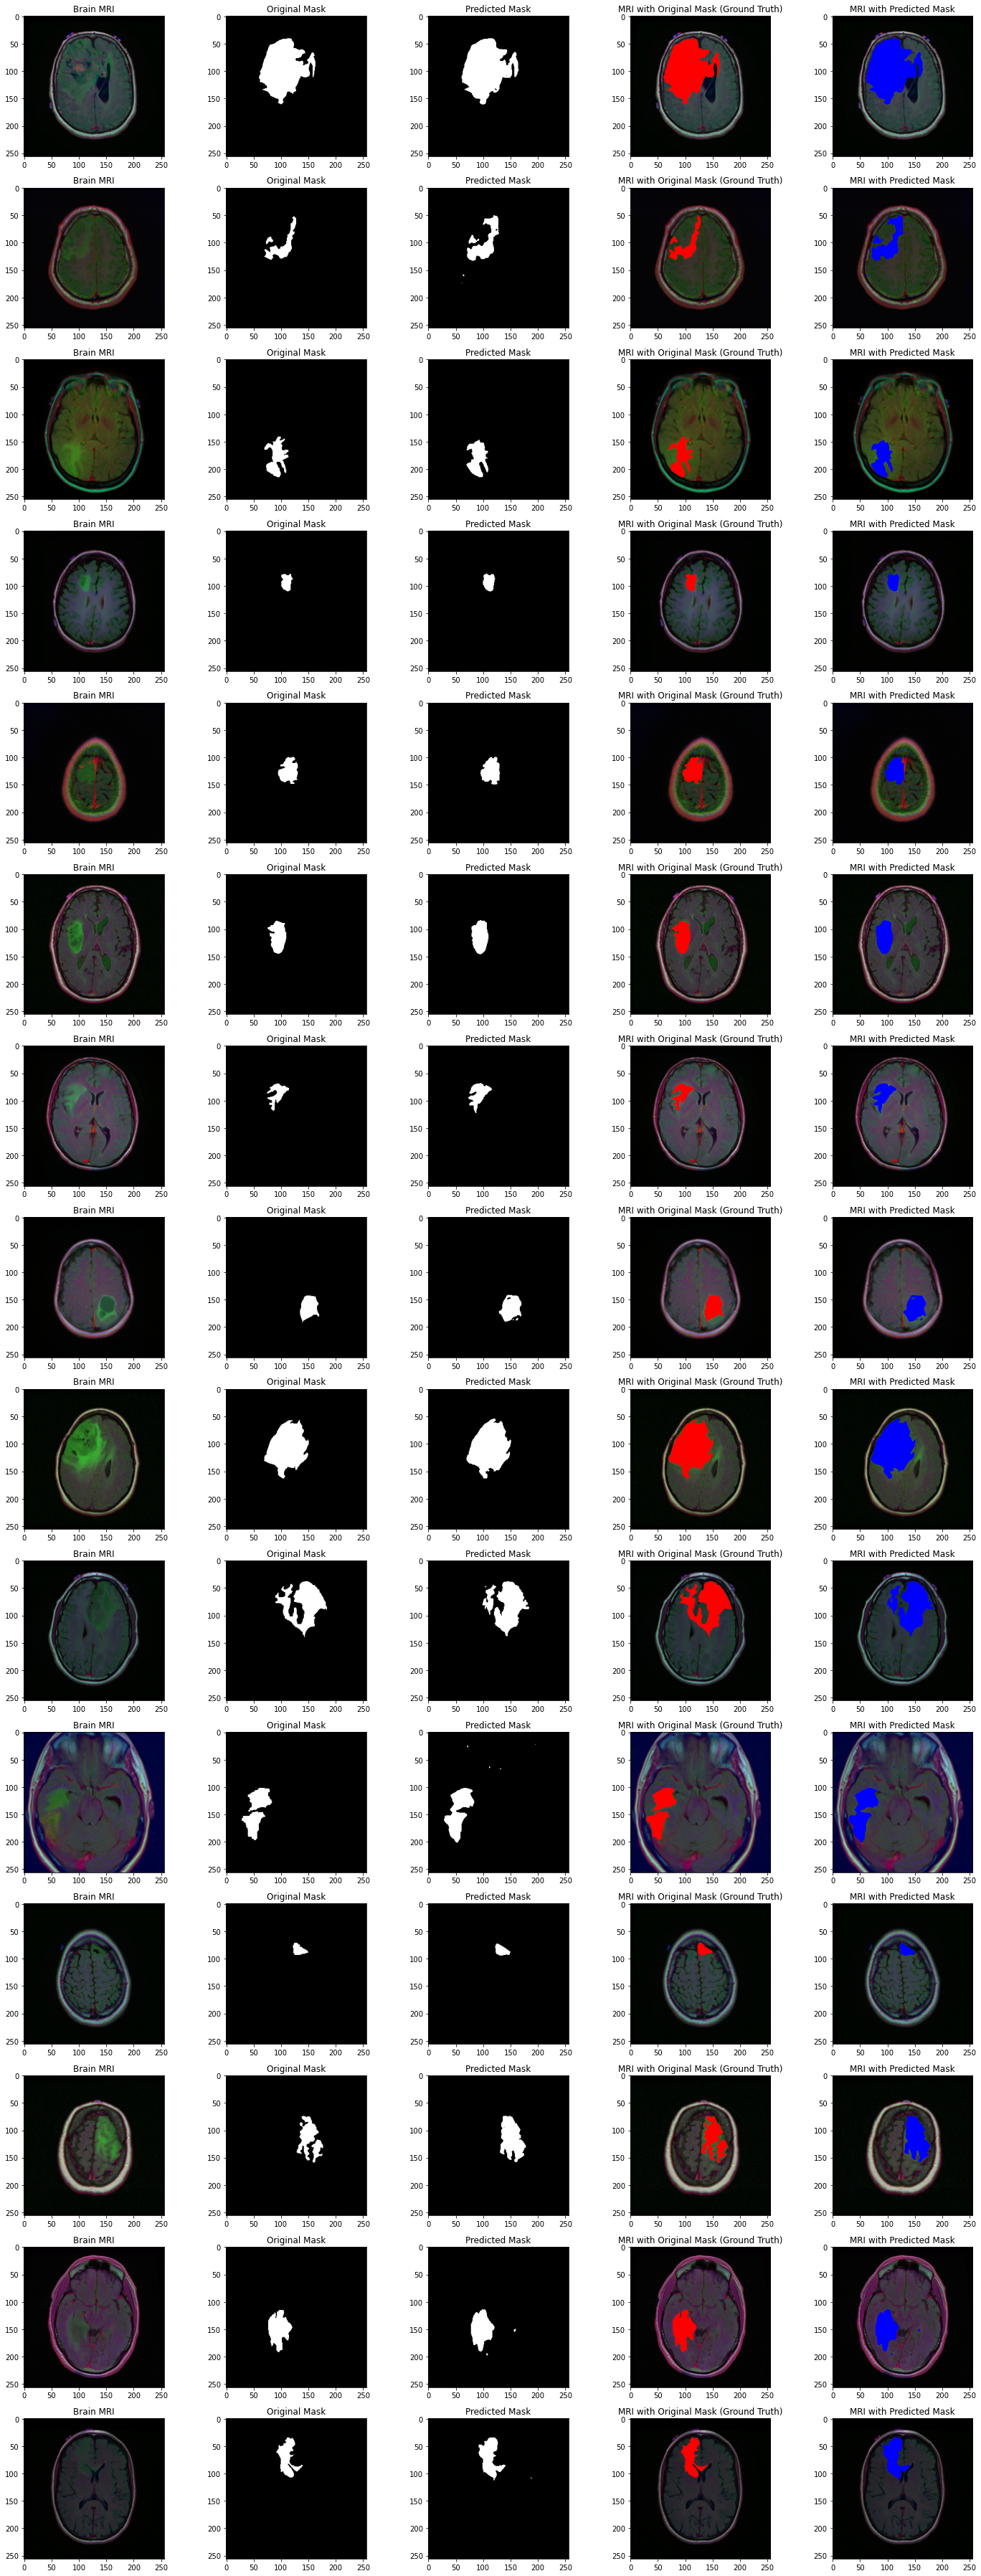

In [100]:
count = 0
fig, axs = plt.subplots(15, 5, figsize=(20, 50))
for i in range(len(comb_df)):
  if comb_df['has_mask'][i] == 1 and count < 15:
    # Read the images and convert them to RGB format
    img = io.imread(comb_df.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(comb_df.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask, cmap='gray')

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(comb_df.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("Predicted Mask")
    axs[count][2].imshow(predicted_mask, cmap='gray')

    # Apply the mask to the image
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(comb_df.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 0, 255)
    axs[count][4].title.set_text("MRI with Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()
